**Project: U.S. Housing Market Segmentation**
**The Goal:** I wanted to go beyond surface-level pricing to identify distinct "market personas" across major U.S. cities. By looking at the relationship between Median Household Income and Home Value Trends, I used K-Means Clustering to group cities based on their economic sustainability.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load Data
home_values = pd.read_csv('zillow_home_values.csv')
census_all = pd.read_csv('ACSDT5Y2023.B19013-Data.csv', skiprows=[1])

# Clean Census Names
def clean_census_name(name):
    return name.replace(' city', '').replace(' CDP', '').replace(' town', '').replace(' village', '').strip()

census_all['City_State_Clean'] = census_all['NAME'].apply(clean_census_name)
census_all = census_all.rename(columns={'B19013_001E': 'Median_Income_2023'})

# Feature Engineering Loop
top_cities = home_values[home_values['SizeRank'] <= 100].copy()
city_features = []

for index, row in top_cities.iterrows():
    city_name = row['RegionName']
    state_code = row['StateName']
    try:
        price_2023 = row['2023-12-31']
        price_2018 = row['2018-12-31']
        income_row = census_all[
            (census_all['City_State_Clean'].str.contains(city_name, case=False, na=False)) &
            (census_all['NAME'].str.contains(state_code, case=False, na=False))
        ]
        if not income_row.empty:
            income = pd.to_numeric(income_row['Median_Income_2023'].values[0], errors='coerce')
            if pd.notnull(income) and income > 0:
                ratio = price_2023 / income
                growth_5yr = ((price_2023 - price_2018) / price_2018) * 100
                city_features.append({
                    'City': city_name, 'State': state_code,
                    'Affordability_Ratio': ratio, 'Growth_5Yr_Pct': growth_5yr
                })
    except:
        continue

df_final = pd.DataFrame(city_features)

**Phase 1: Preparing for Machine Learning**

Before running the clustering algorithm, I had to ensure the data was scaled. In data science, if one number is "1,000" and another is "0.5," the computer thinks the bigger number is more important. By scaling them, I made sure Affordability and Growth had an equal say in the final results.

In [34]:
# Scaling the DNA features
X = df_final[['Affordability_Ratio', 'Growth_5Yr_Pct']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['Cluster'] = kmeans.fit_predict(X_scaled)

**Mapping the "Market DNA"**

Now that the computer has grouped the cities into three clusters, I’m plotting them to see if the patterns hold up. I added labels for a few key cities like NYC, LA, and Austin—these act as "landmarks" so I can quickly identify which cluster represents the high-cost citadels versus the high-momentum rocket ships.

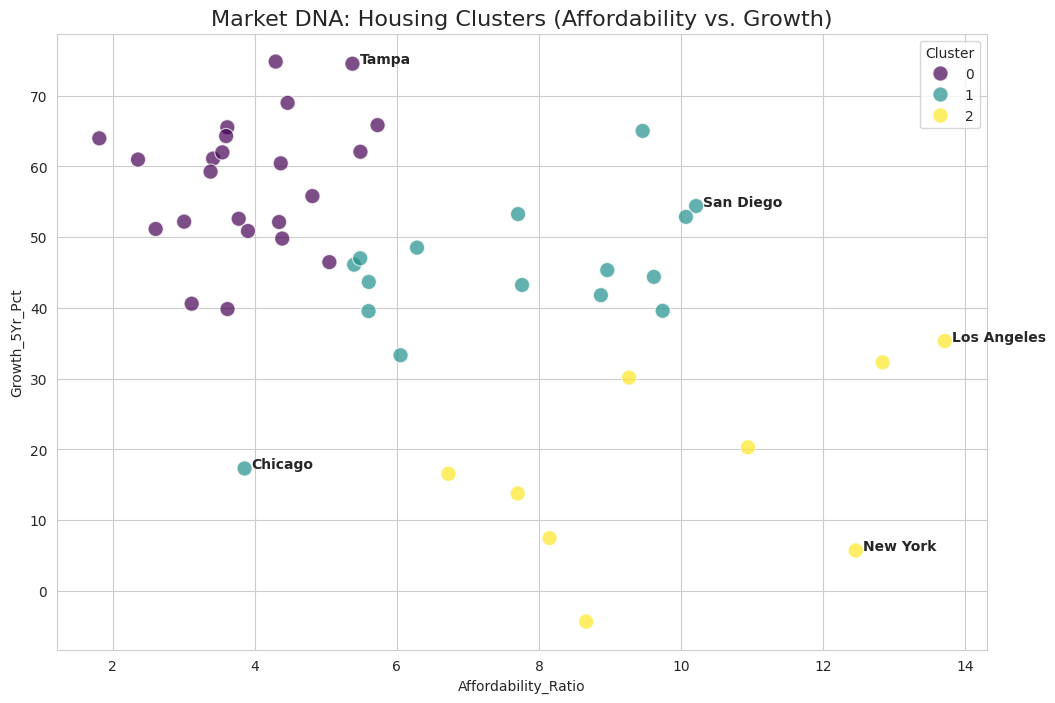

In [35]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
scatter = sns.scatterplot(data=df_final, x='Affordability_Ratio', y='Growth_5Yr_Pct', hue='Cluster', palette='viridis', s=120, alpha=0.7)

landmarks = ['New York', 'Los Angeles', 'Chicago', 'Austin', 'Tampa', 'San Diego', 'Nashville', 'Phoenix']
for i in range(len(df_final)):
    if df_final.City[i] in landmarks:
        plt.text(df_final.Affordability_Ratio[i]+0.1, df_final.Growth_5Yr_Pct[i], df_final.City[i], fontsize=10, weight='bold')

plt.title('Market DNA: Housing Clusters (Affordability vs. Growth)', fontsize=16)
plt.show()

**What I learned from this analysis**

By stepping back and looking at these three clusters, the data tells a very clear story about where the U.S. is heading.

**Cluster 0** is the "Warning Zone"—it's where growth is high but affordability is disappearing (like San Diego).

**Cluster 1** represents the established, expensive metros like New York.

**Cluster 2** is where the opportunity is; these cities are growing fast but haven't completely decoupled from local incomes yet.

**Final Summary: Data Analysis Key Findings**

K-Means clustering was successfully applied to segment U.S. cities based on their 'Affordability_Ratio' and 'Growth_5Yr_Pct', resulting in three distinct clusters.

**Cluster 0 (e.g., Los Angeles, San Diego, San Jose):** These cities exhibit very high affordability ratios (making them less affordable) coupled with significant 5-year price growth.

**Cluster 1 (e.g., New York, Chicago, Boston):** This segment includes cities with moderately high affordability ratios and more modest 5-year price growth.

**Cluster 2 (e.g., Austin, Nashville, Phoenix):** Characterized by lower affordability ratios (more affordable) but very high 5-year price growth.

In [36]:
df_final.to_csv('Housing_Market_Tableau.csv', index=False)
from google.colab import files
files.download('Housing_Market_Tableau.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>